<a href="https://colab.research.google.com/github/chicknco12/salary-determinants-ml/blob/main/Untitled9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loaded dataset from: Salary_Data.csv
    Age  Gender Education Level          Job Title  Years of Experience  \
0  32.0    Male      Bachelor's  Software Engineer                  5.0   
1  28.0  Female        Master's       Data Analyst                  3.0   
2  45.0    Male             PhD     Senior Manager                 15.0   
3  36.0  Female      Bachelor's    Sales Associate                  7.0   
4  52.0    Male        Master's           Director                 20.0   

     Salary  
0   90000.0  
1   65000.0  
2  150000.0  
3   60000.0  
4  200000.0  

Descriptive statistics:
                Age  Gender  Education                   JobTitle  \
count   1788.000000  1788.0     1788.0                       1788   
unique          NaN     3.0        3.0                        191   
top             NaN     1.0        5.0  Software Engineer Manager   
freq            NaN   967.0     1337.0                        127   
mean      35.135347     NaN        NaN                    

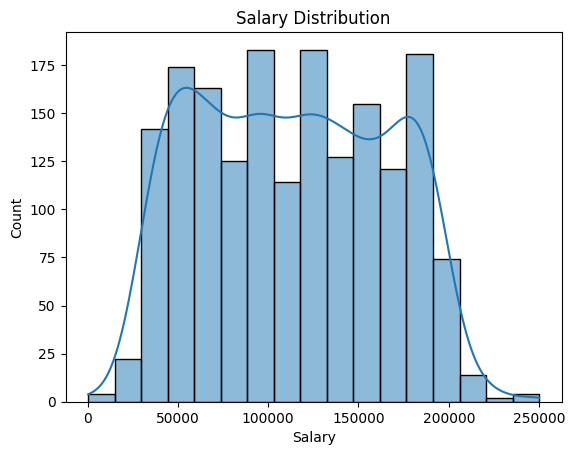

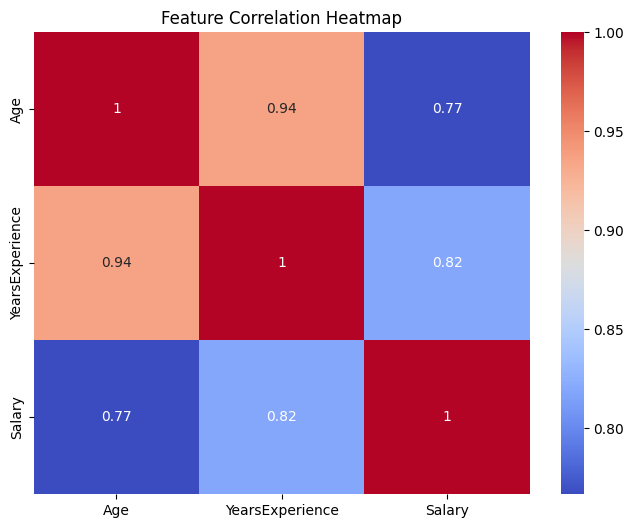


Model performance:
                           RMSE        R²
Random Forest      24898.261720  0.773298
Linear Regression  30918.765678  0.650408


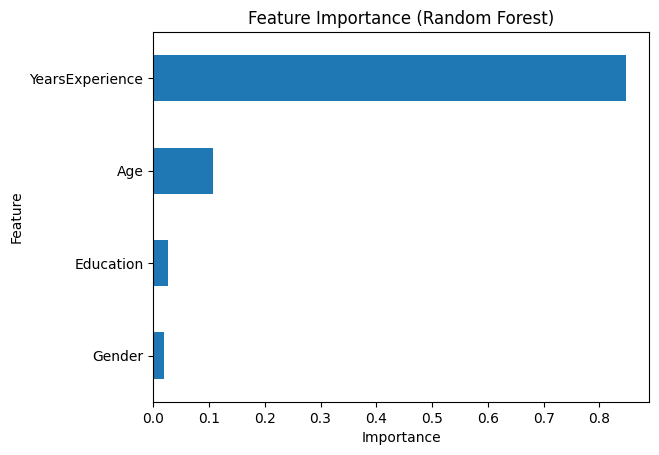

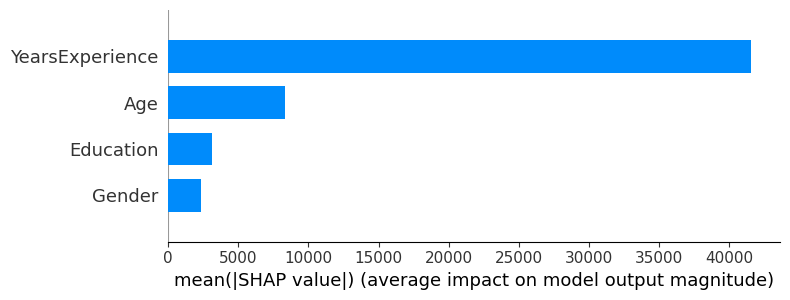

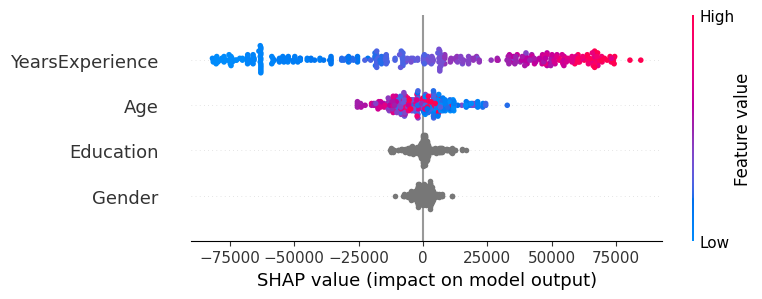


Summary:
- Headers normalized (handled 'Education Level' → Education, 'Years of Experience' → YearsExperience, 'Job Title' → JobTitle).
- Encoded Gender (label) and Education (ordinal).
- Scaled numeric features only (Age, YearsExperience).
- Best model by RMSE: Random Forest
- Metrics:
                           RMSE        R²
Random Forest      24898.261720  0.773298
Linear Regression  30918.765678  0.650408



In [2]:
# -------------------------------------
# 1) Imports
# -------------------------------------
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# SHAP (install if missing)
try:
    import shap
except ImportError:
    !pip -q install shap
    import shap

# Colab upload helper (safe if not in Colab)
try:
    from google.colab import files
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# -------------------------------------
# 2) Load Dataset (path or upload)
# -------------------------------------
CANDIDATE_PATHS = [
    "data/salary_dataset.csv",
    "Salary_Data.csv",
    "salary.csv"
]

df = None
for p in CANDIDATE_PATHS:
    if os.path.exists(p):
        df = pd.read_csv(p)
        print(f"Loaded dataset from: {p}")
        break

if df is None:
    if IN_COLAB:
        print("File not found at common paths. Please upload your CSV.")
        uploaded = files.upload()
        fname = next(iter(uploaded))
        df = pd.read_csv(fname)
        print(f"Loaded dataset from upload: {fname}")
    else:
        raise FileNotFoundError("Dataset not found. Update CANDIDATE_PATHS or provide a valid path.")

print(df.head())

# -------------------------------------
# 3) Normalize headers & clean
# -------------------------------------
# Strip whitespace first
df.columns = df.columns.str.strip()

# Robust renaming: handle both underscores and spaces variants
# We'll normalize to lowercase for matching, then rename original columns.
lower_cols = {c: c.lower() for c in df.columns}
rename_targets = {
    "education_level": "Education",
    "education level": "Education",
    "years_of_experience": "YearsExperience",
    "years of experience": "YearsExperience",
    "job_title": "JobTitle",
    "job title": "JobTitle",
}
rename_map = {}
for original, low in lower_cols.items():
    if low in rename_targets:
        rename_map[original] = rename_targets[low]
# Apply renaming
df = df.rename(columns=rename_map)

# Required columns after renaming
required_cols = ['Age', 'Gender', 'Education', 'YearsExperience', 'Salary']
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected columns: {missing}\nCurrent columns: {list(df.columns)}")

# Basic cleaning
df = df.drop_duplicates().copy()

# Normalize string columns
if 'JobTitle' in df.columns:
    df.loc[:, 'JobTitle'] = df['JobTitle'].astype(str).str.strip().str.title()

df.loc[:, 'Education'] = (
    df['Education'].astype(str)
    .str.replace('.', '', regex=False)
    .str.strip()
    .str.title()
)
df.loc[:, 'Gender'] = df['Gender'].astype(str).str.strip().str.title()

# Drop rows with critical missing values
df = df.dropna(subset=['Salary', 'Age', 'Gender', 'Education', 'YearsExperience']).copy()

# -------------------------------------
# 4) Encoding
# -------------------------------------
# Gender label-encode
le_gender = LabelEncoder()
df.loc[:, 'Gender'] = le_gender.fit_transform(df['Gender'])

# Education ordinal map with fallback
edu_order = ['High School', 'Bachelor', 'Master', 'Phd']
edu_map = {name.title(): i+1 for i, name in enumerate(edu_order)}
df.loc[:, 'Education'] = df['Education'].map(edu_map)

if df['Education'].isna().any():
    # Assign a value just above the max defined ordinal for unknown categories
    max_known = max(edu_map.values()) if edu_map else 0
    df.loc[df['Education'].isna(), 'Education'] = max_known + 1

# -------------------------------------
# 5) Quick EDA
# -------------------------------------
print("\nDescriptive statistics:")
print(df.describe(include='all'))

plt.figure()
sns.histplot(df['Salary'], kde=True)
plt.title("Salary Distribution")
plt.xlabel("Salary")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(8,6))
corr = df[['Age', 'Gender', 'Education', 'YearsExperience', 'Salary']].corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

# -------------------------------------
# 6) Features, Split, Scale
# -------------------------------------
features = ['Age', 'Gender', 'Education', 'YearsExperience']
X = df[features].copy()
y = df['Salary'].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

numeric_cols = ['Age', 'YearsExperience']
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled.loc[:, numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled.loc[:, numeric_cols] = scaler.transform(X_test[numeric_cols])

# -------------------------------------
# 7) Train & Evaluate
# -------------------------------------
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42)
}

results = {}
fitted_models = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))
    r2 = float(r2_score(y_test, y_pred))
    results[name] = {"RMSE": rmse, "R²": r2}
    fitted_models[name] = model

results_df = pd.DataFrame(results).T.sort_values(by="RMSE")
print("\nModel performance:")
print(results_df)

# -------------------------------------
# 8) Feature Importance (RF)
# -------------------------------------
rf = fitted_models["Random Forest"]
importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=True)

plt.figure()
importances.plot(kind='barh', title='Feature Importance (Random Forest)')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# -------------------------------------
# 9) SHAP Explainability (RF)
# -------------------------------------
shap.initjs()
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test_scaled)

# Bar summary
shap.summary_plot(shap_values, X_test_scaled, feature_names=features, plot_type="bar")
# Beeswarm summary
shap.summary_plot(shap_values, X_test_scaled, feature_names=features)

# -------------------------------------
# 10) Conclusion
# -------------------------------------
best_model = results_df.index[0]
print(f"""
Summary:
- Headers normalized (handled 'Education Level' → Education, 'Years of Experience' → YearsExperience, 'Job Title' → JobTitle).
- Encoded Gender (label) and Education (ordinal).
- Scaled numeric features only (Age, YearsExperience).
- Best model by RMSE: {best_model}
- Metrics:
{results_df.to_string()}
""")
